In [2]:
%load_ext autoreload
%autoreload 2

from dotenv import load_dotenv

load_dotenv()

True

In [3]:
# Split into train/test with stratification
from sklearn.calibration import LabelEncoder
from sklearn.model_selection import train_test_split

from lib.examples import examples_df


train_df, test_df = train_test_split(examples_df, test_size=0.3, stratify=examples_df["relation"], random_state=42)

# Encode string labels to integers
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["relation"])
test_df["label"] = label_encoder.transform(test_df["relation"])

In [4]:
from transformers import BertForSequenceClassification, BertTokenizer

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=3
)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

/Users/colegawin/Documents/ling 486 final project/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
from datasets import Dataset


# Tokenization function
def tokenize_batch(batch):
    return tokenizer(batch["concept1"], batch["concept2"], truncation=True, padding="max_length", max_length=32)

# Convert to HF Datasets
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Apply tokenizer
train_dataset = train_dataset.map(tokenize_batch, batched=True)
test_dataset = test_dataset.map(tokenize_batch, batched=True)

# Rename for Trainer API
train_dataset = train_dataset.rename_column("label", "labels")
test_dataset = test_dataset.rename_column("label", "labels")

# Drop unused columns
train_dataset = train_dataset.remove_columns(["concept1", "concept2", "relation", "__index_level_0__"])
test_dataset = test_dataset.remove_columns(["concept1", "concept2", "relation", "__index_level_0__"])

Map: 100%|██████████| 1080/1080 [00:00<00:00, 8946.03 examples/s]


In [6]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./bert-relations",
    num_train_epochs=10,
    logging_dir="./logs",
    save_strategy="no"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer
)

trainer.train()

/var/folders/cj/2g_361zd52gff3mw9lrrzxhm0000gn/T/ipykernel_7860/728105870.py:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/colegawin/Documents/ling 486 final project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
500,0.502700
1000,0.184900
1500,0.039000
2000,0.016000
2500,0.003200
3000,0.001500


TrainOutput(global_step=3150, training_loss=0.11862168671031083, metrics={'train_runtime': 338.2803, 'train_samples_per_second': 74.494, 'train_steps_per_second': 9.312, 'total_flos': 414403632921600.0, 'train_loss': 0.11862168671031083, 'epoch': 10.0})

In [7]:
model.save_pretrained("bert-finetuned-relations")
tokenizer.save_pretrained("bert-finetuned-relations")

('bert-finetuned-relations/tokenizer_config.json',
 'bert-finetuned-relations/special_tokens_map.json',
 'bert-finetuned-relations/vocab.txt',
 'bert-finetuned-relations/added_tokens.json')

/Users/colegawin/Documents/ling 486 final project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


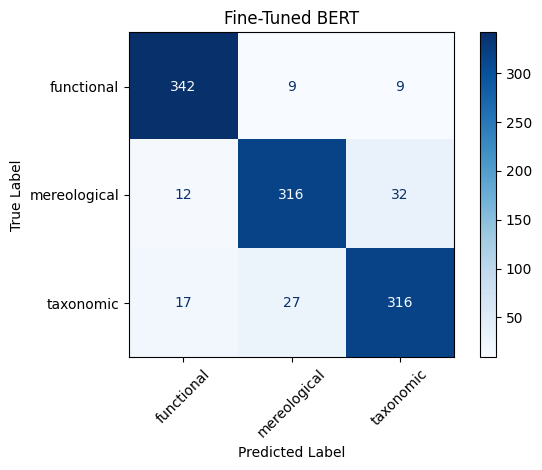

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt


predictions = trainer.predict(test_dataset)

y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Fine-Tuned BERT")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [10]:
from sklearn.metrics import classification_report, cohen_kappa_score

# Classification report (includes precision, recall, f1-score, support per class)
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Cohen's Kappa
kappa = cohen_kappa_score(y_true, y_pred)
print(f"\nCohen's Kappa: {kappa:.4f}")

Classification Report:
              precision    recall  f1-score   support

  functional       0.92      0.95      0.94       360
mereological       0.90      0.88      0.89       360
   taxonomic       0.89      0.88      0.88       360

    accuracy                           0.90      1080
   macro avg       0.90      0.90      0.90      1080
weighted avg       0.90      0.90      0.90      1080


Cohen's Kappa: 0.8528
